<h2>
An Analysis of <i>The Lazy Fundamental Analyst</i>
</br>
by Ian Kaplan
</h2>
<h3>
Introduction
</h3>
<p>
The book <i>The Lazy Fundamental Analyst</i> by Fred Piard, 2014, proposes an investment strategy that utilizes fundamental factors
like Price Earnings (PE) and Return on Assets (ROA) to select stocks within an S&P 500 sector. This is combined with a market timing
signal based on S&P 500 earnings per share momentum and unemployment momentum to hedge the investment portfolio. This notebook
explores the hedging stratagy outlined in Fred Piard's <i>The Lazy Fundamental Analyst</i>  The fundamental factor strategy is not explored
in this notebook because of the time and effort this would require.
</p>
<p>
This Jupyter notebook is opensource, published under the Apache II license. The notebook can be found on
GitHub: <a href="https://github.com/IanLKaplan/lazy_fundamental_analyst">https://github.com/IanLKaplan/lazy_fundamental_analyst</a>
</p>
<h4>
Invest in a Portfolio of ETFs
</h4>
<p>
This is the third Python notebook I have developed that investigates investment strategies outlined in
books aimed at "the average reader". Investing money in a strategy that you read about in a book,
without independently verifing the strategy, is unwise.
The prudent reader, who does not have the skills to perform the type of analysis in this notebook, might be better off investing in
a diversified portfolio of market index ETFs, rather than an investment strategy that they read about in a book.
</p>
<p>
Authors who write for the average investor often use on-line tools (Fred Piard recommends <a href="https://www.portfolio123.com/">
Portfolio 123</a>). These web sites do not disclose how they calculate their portfolio results. Quantitative financial
software can be difficult and it is very easy for the software to contain unrecognized errors. In my previous notebooks there have
been significant differences between my results and the results reported by the author. After extensively checking my results,
I have been unable to find errors in my code, so I am left with the asumption that the error is in the on-line software.
</p>
<h3>
Fundamental Analysis
</h3>
<p>
Fundamental analysis and investing uses corporate statistics like price earnings and return on equity to find companies whose
stock price may be expected to grow. Benjamin Graham, who wrote the book <i>Securities Analysis</i> with David Dodd, published
in 1934, is considered one of the pioneers in fundamental investment analysis. There were six editions of the book. The last
edition included a forward by Graham's most famous student, Warren Buffett. Graham also wrote <i>The Intelligent Investor</i>
which was intended to be a more accessible version of <i>Securities Analysis</i>
</p>
<p>
Warren Buffett, the founder of one of the most successful investment funds in history, Birkshire Hathaway Inc. is one of the
most famous fundamental (or value) investors. From 1956 to 1969 Warren Buffett ran Buffett Partnership. Using a fundamental investment
approach, Buffett's fund was extremely successful, dramatically beating the "market".
</p>
<p>
In his 1967 letter to his investors, Buffett wrote
</p>
<blockquote>
<p>
The results of the first ten years have absolutely no chance of being duplicated or even remotely approximated during the next decade.
</p>
<p>
<a href="https://theirrelevantinvestor.com/2016/06/21/going-out-on-top/">Going Out at the Top</a> by Michael Batnick
</p>
</blockquote>
<p>
After the Great Depression in the 1930s and World War II many people would not invest in the stock market because they
viewed it as being very risky. The United States was one of the few economies that was not shattered
by the destruction of World War II. The stock market grew along with the US economy. This was a time when fundamental analysis
could identify companies with strong prospects of stock price growth.
</p>
<p>
As the stock market grew it attracted more investors and investment firms. More security analysts using the same fundamental
investment approaches that Buffett used meant that there were more "eyes" on companies with potential growth, bidding up their
stock prices.
</p>
<p>
Buffett closed his fund in 1969 and gave his investors the option of leaving their money with him or cashing out. Buffett applied
his abilities in analyzing corporate balance sheets and business to purchasing companies, the first of which was Birkshire Hathaway,
which became the holding company for Buffett's investments. Buffett moved from running an investment fund to running what is now
called a private equity fund.
</p>
<p>
In general, to keep their investors, actively managed investment fund must attempt to beat the "market" (S&P 500) in return or lower risk.
Since the late 1990s, fundamental (or value) investment funds have seriously lagged "the market" in most respects.
Until the dot-com crash in 2000, value funds lagged technology funds.
</p>
<p>
During the 2007-2008 financial crisis western governments instituted "quantitative easing" to avoid a repeat of the Great
Depression. Quantitative easing was also used to avoid a serious recession during the COVID-19 pandemic.
The result was an expansion of the money supply and interest rates near zero. This made bonds and other fixed income investments
unattractive. Investment funds moved to the stock market, regardless of the performance of the overall economy and market fundamentals.
An example of this can be seen in the plot later in this notebook where the S&P 500 (e.g., the SPY ETF) grows as the earnings per
share declines. This contradicts the foundational views of fundamental investment.
</p>
<h3>
Analyzing <i>The Lazy Fundamental Analyst</i>
</h3>
<p>
Fred Paird's book states that it is written for the average investor who is willing to spend a limited amount of time
each month on their investments. Considering the data issues, especially in regard to the data needed to
construct the unemployment momentum signal, the time that must be dedicated to investment may be underestimated.
</p>
<p>
This notebook attempts to verify some of the results reported in the book. In the print edition of the book the plots are
difficult to read and printed in black and white. These plots show the performance of a stock portfolio built from stocks
in each of the S&P 500 sectors. These stocks are selected using fundamental factors. These are sometimes referred to as
factor models, but this is not discussed in Piard's book.
</p>
<p>
The author does not provide any
information on how the fundamental factors for each sector were chosen, other than stating that there was quantitative backtesting
used to choose these factors. Even if these factors were effective predictors for portfolio returns, the market is ever
changing and these factors may not be effective over later dates.
</p>
<p>
The sector portfolios are, generally, unimpressive, lagging the S&P 500 in returns. Along with each sector
portfolio, there is a plot that shows the performance of a portfolio that is hedged on the basis of the author's market
timing signal. The hedged portfolios show higher return and lower risk. This notebook attempts to reproduce
the results of the hedged portfolios.
</p>
<h3>
Market Timing Signals
</h3>
<p>
One of the best ways to make money in investing is to avoid losing money. A variety of market signals have been proposed
that indicate when an investor should move from "risk assets" (stocks, ETFs) to lower risk fixed income assets
like bonds. Technical market signals, like the 200-day moving average (see <a href="https://github.com/IanLKaplan/cash_trigger">
Stock Market Cash Trigger</a>) have been proposed. Fred Piard notes that no market timing signal is perfect and that
there will always be cases where they fail. The hope is that, over all, the market timing signal can deliver lower risk
and higher returns. As is often stated, past performance is no guarantee of future returns. Perhaps the best we can hope for in
a market timing signal is that it is better to use it than ignore it.
</p>
<p>
The book proposes a market timing signal based on S&P 500 yearly earnings per share momentum and unemployment
momentum.
</p>
<h4>
EPS Estimate Momentum
</h4>
<blockquote>
<p>
"EPS Estimate Momentum" is an aggregate fundamental ratio over the S&P 500 Index. It gives a bearish signal when
the S&P 500 current year EPS estimate is below its own value three months previously, and a bullish signal when it is
above this value.
</p>
<p>
<i>The Lazy Fundamental Analyst</i> by Fred Paird
</p>
</blockquote>
<h4>
Unemployment Momentum
</h4>
<blockquote>
<p>
It [Unemployment Momentum] gives a bearish signal when the US enemployment rate is above it's own value three months ago,
and a bullish signal when it is below this value. The US unemployment rate is published once a month, usually in the first half
of the month for the previous month.
</p>
<p>
<i>The Lazy Fundamental Analyst</i> by Fred Paird
</p>
</blockquote>
<p>
When one of the indicators is "bullish", the portfolio is invested in stocks. When the two indicators are "bearish" the
portfolio is hedged against the S&P 500 (for example, via the ETF SH (ProShares 1x Short S&P 500)).
</p>
<h3>
Market Timing Signal, in detail
</h3>
<h4>
EPS Estimate Momentum
</h4>
<p>
Monthly S&P 500 earnings yield, by month, is published on the NASDAQ data site, along with several other S&P 500 statistics. See
<a href="https://data.nasdaq.com/data/MULTPL-sp-500-ratios">S&P 500 Ratios</a>. The data can be retrieved from Python,
using the nasdaqdatalink package (see the import in the code below).
</p>
<p>
The NASDAQ datalink data can, in theory, be retreived using their anonymous API. This worked for me for a few days,
until it started to fail with a "too many data requests" error. To avoid this error, an API account must be registered.
The API account is free for personal and research use.
</p>
<p>
To sign up for an account see
<a href="https://data.nasdaq.com/sign-up">Nasdaq Data Link signup</a>. The NASDAQ
software will use an enviroment variable, NASDAQ_DATA_LINK_API_KEY, set to the key.
</p>
<p>
To set the NASDAQ_DATA_LINK_API_KEY environment variable include this in your setup file (e.g., .bashrc):
</p>
<p>
export NASDAQ_DATA_LINK_API_KEY=[your API key]
</p>
<p>
The data link documentation can be found on the
nasdaq <a href="https://github.com/Nasdaq/data-link-python">GitHub site for nasdaqdatalink</a>.
</p>
<p>
The Nasdaq data is for the monthly S&P 500 earnings yield. Fred Piard's EPS estimate momentum is the yearly sum, so
the estimate for 12 months is summed for the yearly value.
</p>

In [66]:
import os
from datetime import datetime, timedelta
from pathlib import Path
from typing import List, Callable, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# https://data.nasdaq.com/tools/python
# pip install Nasdaq-Data-Link
import nasdaqdatalink as nasd
from pandas import DatetimeIndex

# pip install pandas-datareader
from pandas_datareader import data

import requests
import json
import jsonpickle as jp

import tempfile

plt.style.use('seaborn-whitegrid')

def df_concat(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    """
    Concatenate two DataFrame objects with Datetime indexes. By forcing
    conversion to a Datetime index this can avoid mismatches on
    concatenation due to time (hours, minutes and seconds).
    :param df1:
    :param df2:
    :return:
    """
    df1.index = pd.to_datetime(df1.index)
    df2.index = pd.to_datetime(df2.index)
    df_concat = pd.concat([df1, df2], axis=1)
    return df_concat


def convert_date(some_date):
    if type(some_date) == str:
        some_date = datetime.fromisoformat(some_date)
    elif type(some_date) == np.datetime64:
        ts = (some_date - np.datetime64('1970-01-01T00:00')) / np.timedelta64(1, 's')
        some_date = datetime.utcfromtimestamp(ts)
    return some_date


def findDateIndex(date_index: DatetimeIndex, search_date: datetime) -> int:
    '''
    In a DatetimeIndex, find the index of the date that is nearest to search_date.
    This date will either be equal to search_date or the next date that is less than
    search_date
    '''
    index: int = -1
    i = 0
    search_date = convert_date(search_date)
    date_t = datetime.today()
    for i in range(0, len(date_index)):
        date_t = convert_date(date_index[i])
        if date_t >= search_date:
            break
    if date_t > search_date:
        index = i - 1
    else:
        index = i
    return index


start_date_str = '2007-01-03'
start_date: datetime = datetime.fromisoformat(start_date_str)
# The "current date"
end_date: datetime = datetime.today() - timedelta(days=1)

class NASDQData:
    """
    eps_start_date: the data that the rolling 12-month sum should start at
    """

    def __init__(self, eps_start_date: datetime):
        self.start_date = eps_start_date
        self.S_AND_P_EARNINGS_KEY = "MULTPL/SP500_EARNINGS_YIELD_MONTH"
        self.DATALINK_KEY = 'NASDAQ_DATA_LINK_API_KEY'
        self.s_and_p_earnings_file = "s_and_p_earnings.csv"

    def get_s_and_p_earnings(self) -> pd.DataFrame:
        temp_root: str = tempfile.gettempdir() + '/'
        file_path: str = temp_root + self.s_and_p_earnings_file
        temp_file_path = Path(file_path)
        file_size = 0
        if temp_file_path.exists():
            file_size = temp_file_path.stat().st_size

        if file_size > 0:
            s_and_p_eps_yearly = pd.read_csv(file_path, index_col='Date')
        else:
            nasdaq_datalink_key = os.environ.get(self.DATALINK_KEY)
            if nasdaq_datalink_key == None:
                print("Warning: no NASDAQ data link key has been set in the environment")
            # For all of the S&P ratios see https://data.nasdaq.com/data/MULTPL-sp-500-ratios
            # https://data.nasdaq.com/data/MULTPL/SP500_EARNINGS_YIELD_MONTH-sp-500-earnings-yield-by-month
            try:
                back_start_date = self.start_date - timedelta(weeks=56)
                s_and_p_eps_raw = nasd.get("MULTPL/SP500_EARNINGS_YIELD_MONTH", start_date=back_start_date)
                eps_index = s_and_p_eps_raw.index
                ix_start = findDateIndex(eps_index, self.start_date - timedelta(weeks=52))
                assert ix_start >= 0
                s_and_p_eps = s_and_p_eps_raw[:][ix_start:]
                s_and_p_eps_yearly = s_and_p_eps.rolling(12).sum()
                ix_start = findDateIndex(eps_index, self.start_date)
                assert ix_start >= 0
                s_and_p_eps_yearly = round(s_and_p_eps_yearly[:][ix_start:], 2)
                s_and_p_eps_yearly.to_csv(file_path)
            except Exception as e:
                raise Exception(f'nasdaq-data-link error: {str(e)}')

        return s_and_p_eps_yearly


# The data returned will be the rolling yearly sum, so the start_date is backed up by a year to properly start
# on start-date.
nasdq_data = NASDQData(start_date)
eps_yearly = nasdq_data.get_s_and_p_earnings()

The yearly S&P 500 earnings per share (calculated by summing the rolling monthly earnings per share) is shown below

<AxesSubplot:title={'center':'Yearly S&P 500 Earnings yield'}, xlabel='Date'>

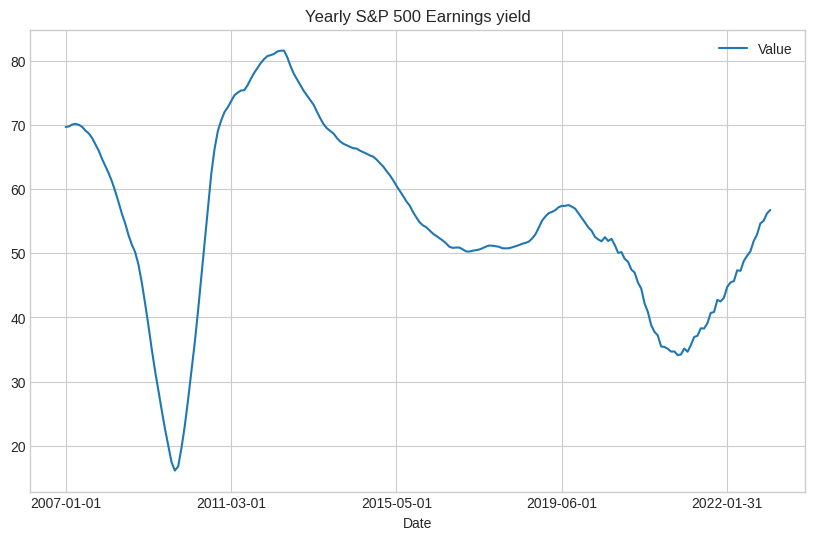

In [67]:

eps_yearly.plot(grid=True, title="Yearly S&P 500 Earnings yield", figsize=(10, 6))


<h4>
Unemployment Momentum
</h4>
<p>
Fred Piard writes that unemployment data "is widely broadcasted on financial and news websites". This is not much help for someone
who wants to perform quantitative analysis using the unemployment rate as a market signal.
</p>
<p>
United States unemployment rate statistics are published by the US Bureau of Labor Statistics. The data can be downloaded
via a REST interface. To do this, a data ID must be used to identify the data set. The data ID for the US seasonally
adjusted unemployment rate is:
</p>
<p>
Data ID: LNS14000000
</p>
<p>
There is a Python library for accessing the BLS data: <a href="https://pypi.org/project/bls-data/">PyBLS</a>.
Unfortunately, this library does not seem to work. The import (from the published code examples) "from pybls.bls_data import BlsData"
shows "bls_data" as being undefined.
</p>
<p>
Fortunately, the BLS web site publishes sample Python code that does not use the PyBLS API. This code
was used as the basis for developing the BLSData class below.
</p>

In [68]:

class BLSData:
    """
    A class that supports reading data from the Bureau of Labor Statistics (BLS)
    REST end point.

    This code is derived from the code published on the web page:
    https://www.bls.gov/developers/api_python.htm

    See also https://www.bd-econ.com/blsapi.html

    start_year: the numerical year (e.g., 2007) as a string
    end_year: same as start_year  start_year <= end_year

    This class writes the data out to a temp file, so that the file can be read
    in subsequent runs.  This avoids running into the BLS daily download limit.
    This also improves performance.
    """
    def __init__(self, start_year: str, end_year: str):
        self.start_year = start_year
        self.end_year = end_year
        self.unemployment_data_id = 'LNS14000000'
        self.bls_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
        self.headers = {'Content-type': 'application/json'}
        self.max_years = 10
        self.bls_file_name = 'bls_monthly_unemployment.csv'

    def http_request(self, start_year: int, end_year: int) -> str:
        request_json_str = {'seriesid': [self.unemployment_data_id],
                            'startyear': str(start_year),
                            'endyear': str(end_year)}
        request_json = json.dumps(request_json_str)
        http_data = requests.post(self.bls_url, data=request_json, headers=self.headers)
        return http_data.text

    def fetch_data(self, start_year: int, end_year: int) -> pd.DataFrame:
        # The JSON for 'item' in the code below is:
        # {'year': '2016',
        # 'period': 'M12',
        # 'periodName': 'December',
        # 'value': '4.7',
        #  'footnotes': [{}]}
        #
        json_str = self.http_request(start_year, end_year)
        json_dict = jp.decode(json_str)
        status = json_dict['status']
        if status != 'REQUEST_SUCCEEDED':
            raise Exception(json_dict['message'])
        date_l = list()
        value_l = list()
        for series in json_dict['Results']['series']:
            for item in series['data']:
                year = item['year']
                period = item['period']
                value = float(item['value'])
                period_date = datetime(year=int(year), month=int(period[1:]), day=1)
                value_l.append(value)
                date_l.append(period_date)
        period_df = pd.DataFrame(value_l)
        period_df.index = date_l
        # Make sure that dates are in increasing order
        period_df.sort_index(inplace=True)
        return period_df

    def get_unemployment_data_from_bls(self) -> pd.DataFrame:
        start_year_i = int(self.start_year)
        end_year_i = int(self.end_year)
        unemployment_df = pd.DataFrame()
        while start_year_i < end_year_i:
            period_end = min(((start_year_i + self.max_years) - 1), end_year_i)
            period_data_df = self.fetch_data(start_year_i, period_end)
            unemployment_df = pd.concat([unemployment_df, period_data_df], axis=0)
            delta = (period_end - start_year_i) + 1
            start_year_i = start_year_i + delta
        unemployment_df.columns = ['unemployment']
        unemployment_df.index.name = 'Date'
        return unemployment_df

    def get_unemployment_data(self) -> pd.DataFrame:
        temp_root: str = tempfile.gettempdir() + '/'
        file_path: str = temp_root + self.bls_file_name
        temp_file_path = Path(file_path)
        file_size = 0
        if temp_file_path.exists():
            file_size = temp_file_path.stat().st_size

        if file_size > 0:
            unemployment_data_df = pd.read_csv(file_path, index_col='Date')
        else:
            unemployment_data_df = self.get_unemployment_data_from_bls()
            unemployment_data_df.to_csv(file_path)
        return unemployment_data_df


bls_start_year: str = '2007'
bls_end_year: str = str(datetime.today().year)
bls_data = BLSData(bls_start_year, bls_end_year)

bls_unemployment_df = round(bls_data.get_unemployment_data(), 2)

<p>
The plot below shows the seasonaly adjusted monthly unemployment data retrieved from the US Bureau of Labor Statistics (BLS)
</p>

<AxesSubplot:title={'center':'Monthly Unemployment Rate (percent)'}, xlabel='Date'>

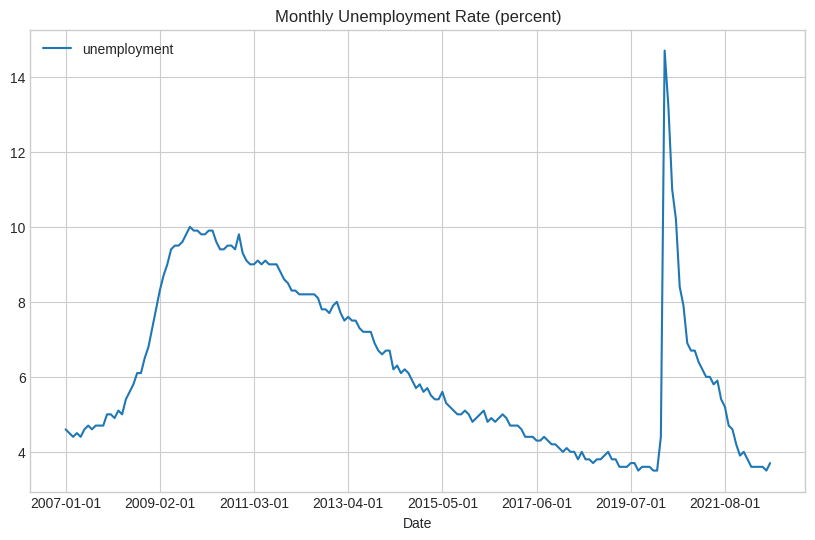

In [69]:

bls_unemployment_df.plot(grid=True, title='Monthly Unemployment Rate (percent)', figsize=(10, 6))


<h3>
Market Signals
</h3>
<p>
In this section we look at the market timing signal that combines the S&P 500 yearly earnings momentum and employment momentum signals.
</p>
<p>
The signals are looked at individually and together. In the book, the portfolio is hedged when both signals are
"bearish".
</p>


In [70]:
def get_market_data(file_name: str,
                    data_col: str,
                    symbols: List,
                    data_source: str,
                    start_date: datetime,
                    end_date: datetime) -> pd.DataFrame:
    """
      file_name: the file name in the temp directory that will be used to store the data
      data_col: the type of data - 'Adj Close', 'Close', 'High', 'Low', 'Open', Volume'
      symbols: a list of symbols to fetch data for
      data_source: yahoo, etc...
      start_date: the start date for the time series
      end_date: the end data for the time series
      Returns: a Pandas DataFrame containing the data.

      If a file of market data does not already exist in the temporary directory, fetch it from the
      data_source.
    """
    temp_root: str = tempfile.gettempdir() + '/'
    file_path: str = temp_root + file_name
    temp_file_path = Path(file_path)
    file_size = 0
    if temp_file_path.exists():
        file_size = temp_file_path.stat().st_size

    if file_size > 0:
        close_data = pd.read_csv(file_path, index_col='Date')
    else:
        if type(symbols) == str:
            t = list()
            t.append(symbols)
            symbols = t
        panel_data: pd.DataFrame = data.DataReader(symbols, data_source, start_date, end_date)
        close_data: pd.DataFrame = panel_data[data_col]
        close_data.to_csv(file_path)
    assert len(close_data) > 0, f'Error reading data for {symbols}'
    ix = close_data.index
    if type(ix) == pd.Index:
        ix = pd.to_datetime(ix)
        close_data.index = ix
    return close_data


def increasing(data_df: pd.DataFrame, window: int) -> list:
    bullish_ix: List[int] = list()
    for i in range(window, data_df.shape[0]):
        if data_df.iloc[i].values[0] > data_df.iloc[i - window].values[0]:
            bullish_ix.append(i)
    return bullish_ix


def decreasing(data_df: pd.DataFrame, window: int) -> list:
    bearish_ix: List[int] = list()
    for i in range(window, data_df.shape[0]):
        if data_df.iloc[i].values[0] < data_df.iloc[i - window].values[0]:
            bearish_ix.append(i)
    return bearish_ix


def signal_dates(func: Callable, data_df: pd.DataFrame, window: int) -> DatetimeIndex:
    ix_l: List[int] = func(data_df, window)
    index = data_df.index
    dates = index[ix_l]
    return dates


def plot_hedge(instrument_df: pd.DataFrame, hedge_df: pd.DataFrame, title: str) -> None:
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    fig.autofmt_xdate()
    ax.plot(instrument_df, label=str(instrument_df.columns[0]))
    ax.plot(hedge_df, 'x', label=str(hedge_df.columns[0]))
    plt.title(title)
    ax.grid(visible=True)
    leg = ax.legend()
    plt.xlabel('Date')
    plt.ylabel('Close Price')


def get_market_indexes(market_df: pd.DataFrame, index_dates: DatetimeIndex) -> List[int]:
    ix_l: List = list()
    market_index = market_df.index
    for date_ in index_dates:
        ix = findDateIndex(date_index=market_index, search_date=date_)
        if ix >= 0:
            ix_l.append(ix)
        else:
            print(f'Did not find date {date_}')
    return ix_l

# The EPS and unemployment data is monthly data, so the window size is three
eps_bullish_dates = signal_dates(increasing, eps_yearly, window=3)
emp_bullish_dates = signal_dates(decreasing, bls_unemployment_df, window=3)

eps_bearish_dates: pd.DatetimeIndex = signal_dates(decreasing, eps_yearly, window=3)
emp_bearish_dates: pd.DatetimeIndex = signal_dates(increasing, bls_unemployment_df, window=3)

spy_data_file = 'spy_adj_close.csv'
spy_close_df = get_market_data(file_name=spy_data_file,
                               data_col='Adj Close',
                               symbols=['spy'],
                               data_source='yahoo',
                               start_date=start_date,
                               end_date=end_date)


<h4>
Yearly S&P Earnings Per Share Momentum Signal
</h4>
<p>
When the current S&P 500 estimate is below the previous three month estimate, the signal is considered bearish.
</p>
<p>
The plot below shows the S&P 500 (SPY ETF) in blue. The red 'x' points in the graph are the months where this signal
is "bearish".
</p>
<p>
The yearly S&P EPS indicator is bearish during the 2008 financial crisis. From mid-2012 through 2017 the earnings per
share declined, while the S&P 500 grew. This is a demonstration that fundamental (value) factors are not necessarily
predictive of future returns in a time where interest rates are near zero.
</p>

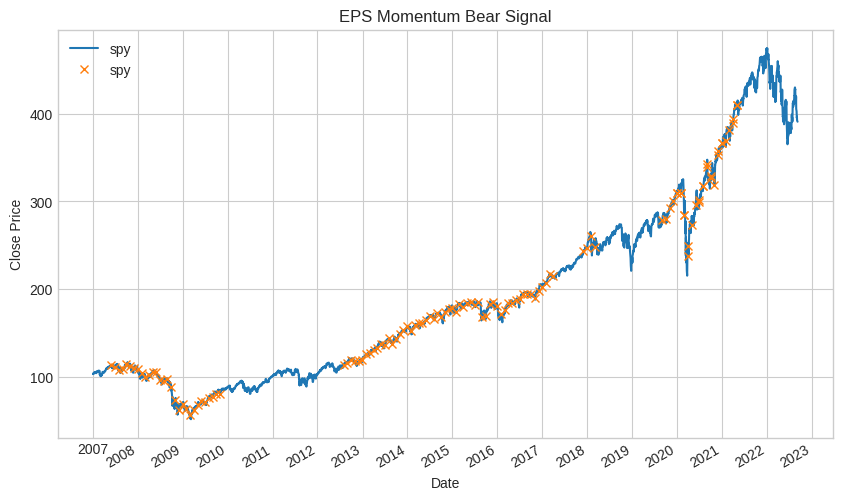

In [71]:
eps_ix_l = get_market_indexes(spy_close_df, eps_bearish_dates)
spy_eps_bear_df = spy_close_df.iloc[eps_ix_l]
plot_hedge(spy_close_df, spy_eps_bear_df, 'EPS Momentum Bear Signal')


<p>
If this signal were used alone to define the hedge period, there could be signifant losses in an S&P 500 short position.
</p>
<h4>
Monthly Employment Bearish Signal
</h4>
<p>
When the current monthly unemployment is below the previous three month employment value, the signal is considered bearish.
This is a "bearish" signal over the 20089 financial crisis and around the 2020 COVID-19 market crash.
</p>

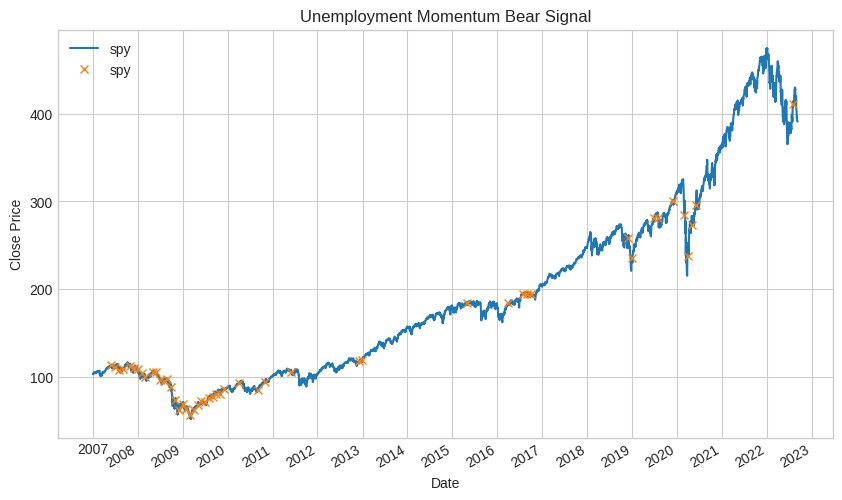

In [72]:
emp_ix_l = get_market_indexes(spy_close_df, emp_bearish_dates)
spy_emp_bear_df = spy_close_df.iloc[emp_ix_l]
plot_hedge(spy_close_df, spy_emp_bear_df, "Unemployment Momentum Bear Signal")


<h4>
Yearly S&P 500 EPS and Unemployment Bear Signal
</h4>
<p>
In the book Fred Paird writes that when both of the market timing signals are "bearish", the portfolio is hedged with a
short position in the S&P 500.
</p>
<p>
The plot below shows the months where both market timing signals are "bearish".
</p>

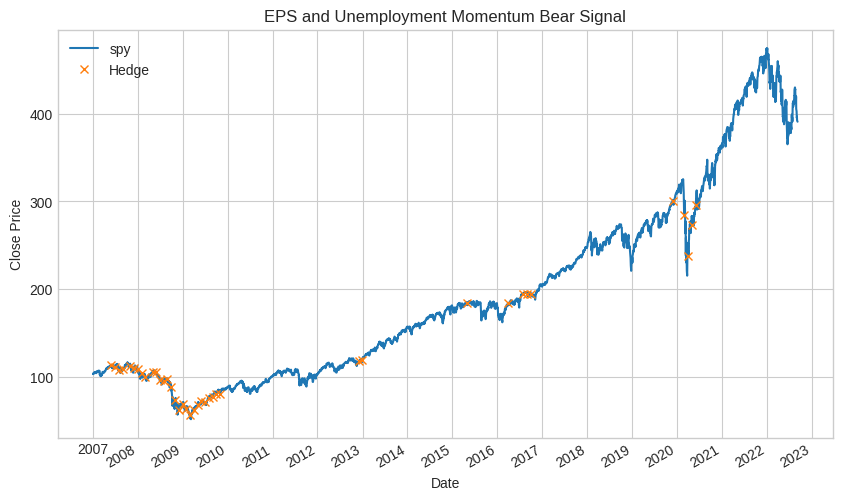

In [73]:
if len(eps_bearish_dates) >= len(emp_bearish_dates):
    bearish_dates_ = emp_bearish_dates.isin(eps_bearish_dates)
    bearish_dates = emp_bearish_dates[bearish_dates_]
else:
    bearish_dates_ = eps_bearish_dates.isin(emp_bearish_dates)
    bearish_dates = eps_bearish_dates[bearish_dates_]


ix_l = get_market_indexes(spy_close_df, bearish_dates)
spy_bear_df: pd.DataFrame = spy_close_df.iloc[ix_l]
spy_bear_df.columns = ['Hedge']

plot_hedge(spy_close_df, spy_bear_df, 'EPS and Unemployment Momentum Bear Signal')

<p>
The market timing signal does a good job of identifying the 2008 financial crisis and some subsequent market dips.
The signal appears less effective over the COVID-19 crash where it indicates a market short when the market is rising.
This is due to the fact that it is a three month signal and the market crash was very short lived.
</p>
<p>
The market timing signal does not work well in the 2022 market decline.
</p>
<h3>
Market Hedging
</h3>
<p>
When the market timing indicator is "bearish", the portfoio is hedged with an equal short position in the
S&P 500. Such a short can be realized in a number of ways, including options and
<a href="https://www.cmegroup.com/education/whitepapers/hedging-with-e-mini-sp-500-future.html">S&P 500 E-mini futures</a>.
To keep the analysis simple, the SH ETF, which takes a 1x short position in the S&P 500, is used.
</p>
<p>
The investment portfolio is divided into two equal halves. Each month the market timing signal will be checked.
When one market timing signal is "bullish" both havles of the portfolio will be invested in the
portfolio (e.g., QQQ or a sector ETF). When the signal is "bearish", one half will remain in the investment portfolio
(e.g., QQQ or a sector ETF) and the other half will be allocated to SH to hedge the portfolio position. If the market signal
moves from bearish to bullish, the SH position will be sold and the portfolio asset will be purchased.
</p>
<p>
For a taxible investment portfolio, the market hedge may reduce losses and short term capital gains taxes. The hedge allows
half of the portfolio assets to be held long term, while the other half is traded to produce the hedge.
</p>
<h3>
Equity ETFs
</h3>
<p>
The ETFs used to investigate the effectiveness of the market timing signal are listed below. The QQQ ETF is a broad market
ETF, but differs from SPY.
</p>
<p>
<i>The Lazy Fundamental Analyst</i> looks at S&P 500 sector portfolios based on sector stocks selected for their factor
characteristics. Sector ETFs, consisting of all of the stocks in a sector are used here. If factors are effective in selecting
sector stocks, these portfolios should out perform the sector ETFs. The sector ETFs should still provide some measure for how effective
the market timing is, when applied to a sector.
</p>
<p>
If market timing delivers less risk and/or higher returns, the market timing signal could be combined with ETF sector
rotation (see <a href="https://github.com/IanLKaplan/twelve_percent">ETF Rotation</a> by Ian Kaplan).  All of the ETFs
below have inception dates before 2007.
</p>

<ul>
<li>
<p>
QQQ - Invesco QQQ Trust
</p>
<p>
Inception Date: 03/10/1999
</p>
</li>

<li>
<p>
XLE - Energy Select Sector SPDR Fund
</p>
<p>
Inception Date: 12/16/1998
</p>
</li>


<li>
<p>
VDC - Vanguard Consumer Staples ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VCR - Vanguard Consumer Discretionary ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VFH - Vanguard Financials ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VGT - Vanguard Information Technology ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>

<li>
<p>
VHT - Vanguard Health Care ETF
</p>
<p>
Inception Date: 01/26/2004
</p>
</li>
</ul>

<h3>
QQQ with Market Timing
</h3>
<p>
This section investigates a portfolio consisting of the QQQ ETF, hedged with SH.
</p>
<p>
The QQQ ETF differs from the SPY S&P 500 ETF.
</p>
<blockquote>
<p>
QQQ is one of the best established and typically one of the most actively traded ETFs in the world. Often referred to as “the triple Q’s”, it's also one of the most unusual. The product is one of a few ETFs structured as a unit investment trust. Per the rules of its index, the fund only invests in nonfinancial stocks listed on NASDAQ, and effectively ignores other sectors too, causing it to skew massively away from a broad-based large-cap portfolio. QQQ has huge tech exposure, but it is not a 'tech fund' in the pure sense either. The fund's arcane weighting rules further distance it from anything close to plain vanilla large-cap or pure-play tech coverage. The ETF is much more concentrated in its top holdings and is more volatile than our vanilla large-cap benchmark. Still, the fund has huge name recognition for the underlying index, the NASDAQ-100. In all, QQQ delivers a quirky but wildly popular mash-up of tech, growth and large-cap exposure. The fund and index are rebalanced quarterly and reconstituted annually.
</p>
<p>
<a href="https://www.etf.com/QQQ">QQQ summary from etf.com</a>
</p>
</blockquote>


In [74]:
sh_data_file = 'sh_close.csv'
sh_close_df = get_market_data(file_name=sh_data_file,
                               data_col='Close',
                               symbols=['sh'],
                               data_source='yahoo',
                               start_date=start_date,
                               end_date=end_date)

qqq_data_file = 'qqq_close.csv'
qqq_close_df = get_market_data(file_name=qqq_data_file,
                               data_col='Close',
                               symbols=['qqq'],
                               data_source='yahoo',
                               start_date=start_date,
                               end_date=end_date)

spy_and_sh_df = df_concat(spy_close_df, sh_close_df)


<p>
The plot below shows the close prices for the SPY S&P 500 tracking ETF and the SH inverse S&P 500 ETF
</p>

<AxesSubplot:title={'center':'SPY and SH'}, xlabel='Date'>

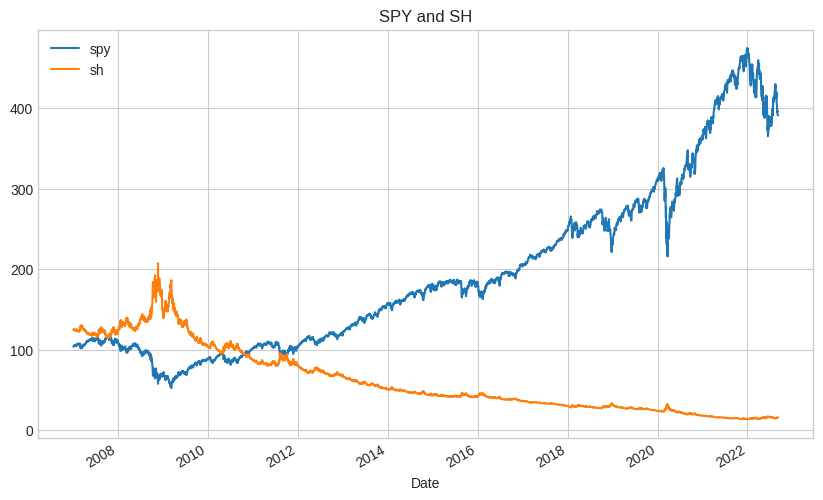

In [75]:


spy_and_sh_df.plot(grid=True, title='SPY and SH', figsize=(10,6))


In [76]:
def find_month_periods(start_date: datetime, end_date: datetime, data: pd.DataFrame) -> pd.DataFrame:
    start_date = convert_date(start_date)
    end_date = convert_date(end_date)
    date_index = data.index
    start_ix = findDateIndex(date_index, start_date)
    end_ix = findDateIndex(date_index, end_date)
    start_l = list()
    end_l = list()
    cur_month = start_date.month
    start_l.append(start_ix)
    i = 0
    for i in range(start_ix, end_ix + 1):
        date_i = convert_date(date_index[i])
        if date_i.month != cur_month:
            end_l.append(i - 1)
            start_l.append(i)
            cur_month = date_i.month
    end_l.append(i)
    # if there is not a full month period, remove the last period
    if end_l[-1] - start_l[-1] < 18:
        end_l.pop()
        start_l.pop()
    start_df = pd.DataFrame(start_l)
    end_df = pd.DataFrame(end_l)
    start_date_df = pd.DataFrame(date_index[start_l])
    end_date_df = pd.DataFrame(date_index[end_l])
    periods_df = pd.concat([start_df, start_date_df, end_df, end_date_df], axis=1)
    periods_df.columns = ['start_ix', 'start_date', 'end_ix', 'end_date']
    return periods_df


def collapse_asset_df(asset_df: pd.DataFrame) -> pd.DataFrame:
    """

    :param asset_df: columns: asset, start_date, end_date
    :return:
    """
    row_l = list()
    row = asset_df[0:1]
    cur_asset = row['asset'][0]
    row_l.append(row)
    row_ix = 0
    for index in range(1, asset_df.shape[0]):
        next_row = asset_df[:][index:index + 1]
        next_asset = next_row['asset'][0]
        if next_asset == cur_asset:
            next_end_date = next_row['end_date'][0]
            last_row = row_l[row_ix]
            last_row.columns = asset_df.columns
            t_l = [last_row['asset'][0], last_row['start_date'][0], next_end_date]
            t_df = pd.DataFrame(t_l).transpose()
            t_df.columns = asset_df.columns
            row_l[row_ix] = t_df
        else:
            row_l.append(next_row)
            row_ix = row_ix + 1
            cur_asset = next_asset
    collapse_df = pd.DataFrame()
    for i in range(len(row_l)):
        collapse_df = pd.concat([collapse_df, row_l[i]], axis=0)
    return collapse_df


def hedge_portfolio(yearly_eps: pd.DataFrame, unemployment: pd.DataFrame, start_date: datetime) -> bool:
    """
    All dates for the EPS data and the unemployment date are on the first of the month
    :param start_date:
    :return:
    """
    window = 3
    index_date = datetime(start_date.year, start_date.month, 1)
    eps_index = yearly_eps.index
    eps_ix_now = findDateIndex(eps_index, index_date)
    eps_ix_past = eps_ix_now - window
    assert eps_ix_past >= 0
    unemployment_index = unemployment.index
    emp_ix_now = findDateIndex(unemployment_index, index_date)
    emp_ix_past = emp_ix_now - window
    assert emp_ix_past >= 0
    hedge = False
    # If yearly S&P 500 earnings per share is lower than three months ago and
    # unemployment is higher than it was three months ago, then hedge is true, otherwise, false
    if (yearly_eps.iloc[eps_ix_now].values[0] < yearly_eps.iloc[eps_ix_past].values[0]) and \
            (unemployment.iloc[emp_ix_now].values[0] > unemployment.iloc[emp_ix_past].values[0]):
        hedge = True
    return hedge


def get_portfolio_hedge(portfolio_asset: pd.DataFrame,
                        hedge_asset_sym: str,
                        start_date: datetime,
                        end_date: datetime,
                        yearly_eps: pd.DataFrame,
                        unemployment: pd.DataFrame) -> pd.DataFrame:
    """
    :param portfolio_asset:
    :param hedge_asset_sym:
    :param start_date:
    :param end_date:
    :return:
    """
    name_l: List = []
    date_l: List = []
    end_date_l: List = []
    month_periods = find_month_periods(start_date, end_date, portfolio_asset)
    for index, period in month_periods.iterrows():
        period_start_date: datetime = convert_date(period['start_date'])
        period_end_date: datetime = convert_date(period['end_date'])
        date_l.append(period_start_date)
        end_date_l.append(period_end_date)
        asset_name = portfolio_asset.columns[0]
        if hedge_portfolio(yearly_eps, unemployment, period_start_date):
            asset_name = hedge_asset_sym
        name_l.append(asset_name)
    asset_df = pd.DataFrame([name_l, date_l, end_date_l]).transpose()
    asset_df.index = date_l
    asset_df.columns = ['asset', 'start_date', 'end_date']
    asset_df = collapse_asset_df(asset_df=asset_df)
    return asset_df


def simple_return(time_series: np.array, period: int = 1) -> List:
    return list(((time_series[i] / time_series[i - period]) - 1.0 for i in range(period, len(time_series), period)))


def return_df(time_series_df: pd.DataFrame) -> pd.DataFrame:
    r_df: pd.DataFrame = pd.DataFrame()
    time_series_a: np.array = time_series_df.values
    return_l = simple_return(time_series_a, 1)
    r_df = pd.DataFrame(return_l)
    date_index = time_series_df.index
    r_df.index = date_index[1:len(date_index)]
    r_df.columns = time_series_df.columns
    return r_df


def adjust_time_series(ts_one_df: pd.DataFrame, ts_two_df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Adjust two DataFrame time series with overlapping date indices so that they
    are the same length with the same date indices.
    """
    ts_one_index = pd.to_datetime(ts_one_df.index)
    ts_two_index = pd.to_datetime(ts_two_df.index)
    # filter the close prices
    matching_dates = ts_one_index.isin(ts_two_index)
    ts_one_adj = ts_one_df[matching_dates]
    # filter the rf_prices
    ts_one_index = pd.to_datetime(ts_one_adj.index)
    matching_dates = ts_two_index.isin(ts_one_index)
    ts_two_adj = ts_two_df[matching_dates]
    return ts_one_adj, ts_two_adj


def apply_return(start_val: float, return_df: pd.DataFrame) -> np.array:
    port_a: np.array = np.zeros(return_df.shape[0] + 1)
    port_a[0] = start_val
    return_a = return_df.values
    for i in range(1, len(port_a)):
        port_a[i] = port_a[i - 1] + port_a[i - 1] * return_a[i - 1]
    return port_a


def build_plot_data(holdings: float, portfolio_df: pd.DataFrame, spy_df: pd.DataFrame) -> pd.DataFrame:
    t_port_df, t_spy_df = adjust_time_series(portfolio_df, spy_df)
    spy_return = return_df(t_spy_df)
    spy_return_a = apply_return(start_val=holdings, return_df=spy_return)
    spy_port = pd.DataFrame(spy_return_a)
    spy_port.columns = ['SPY']
    spy_port.index = pd.to_datetime(t_spy_df.index)
    plot_df = t_port_df.copy()
    plot_df['SPY'] = spy_port
    return plot_df


def hedge_return(portfolio_asset: pd.DataFrame,
                 hedge_asset: pd.DataFrame,
                 start_date: datetime,
                 end_date: datetime,
                 yearly_eps: pd.DataFrame,
                 unemployment: pd.DataFrame) -> pd.DataFrame:
    portfolio_start = datetime(start_date.year, start_date.month, start_date.day)

    # asset_periods has the columns ['asset', 'start_date', 'end_date']
    asset_periods = get_portfolio_hedge(portfolio_asset=portfolio_asset, hedge_asset_sym=hedge_asset.columns[0],
                                        start_date=portfolio_start, end_date=end_date, yearly_eps=yearly_eps,
                                        unemployment=unemployment)
    composit_df = pd.concat([portfolio_asset, hedge_asset], axis=1)
    portfolio_index = composit_df.index
    all_return = pd.DataFrame()
    for index, period in asset_periods.iterrows():
        period_start_date = period['start_date']
        period_end_date = period['end_date']
        period_start_ix = findDateIndex(date_index=portfolio_index, search_date=period_start_date)
        period_end_ix = findDateIndex(date_index=portfolio_index, search_date=period_end_date)
        asset = period['asset']
        period_s = composit_df[asset][period_start_ix - 1:period_end_ix + 1]
        period_df = pd.DataFrame(period_s)
        period_df.columns = ['return']
        period_return_df = return_df(period_df)
        all_return = pd.concat([all_return, period_return_df], axis=0)
    start_period = asset_periods.iloc[0]
    end_period = asset_periods.iloc[-1]
    range_start_date = start_period['start_date']
    range_end_date = end_period['end_date']
    range_start_ix = findDateIndex(date_index=portfolio_index, search_date=range_start_date)
    range_end_ix = findDateIndex(date_index=portfolio_index, search_date=range_end_date)
    result_index = portfolio_index[range_start_ix:range_end_ix + 1]
    all_return.index = result_index
    return all_return


def asset_return(asset_df: pd.DataFrame, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    asset_index = asset_df.index
    start_ix = findDateIndex(date_index=asset_index, search_date=start_date)
    end_ix = findDateIndex(date_index=asset_index, search_date=end_date)
    assert start_ix > 0 and end_ix > 0
    period_df = asset_df[:][start_ix - 1:end_ix + 1]
    period_r = return_df(period_df)
    return period_r


def get_start_end_dates(data_df: pd.DataFrame) -> Tuple[datetime, datetime]:
    num_rows = data_df.shape[0]
    first_row = data_df[:][0:1]
    last_row = data_df[:][num_rows - 1:num_rows]
    start_date = convert_date(first_row.index[0])
    end_date = convert_date(last_row.index[0])
    return start_date, end_date


def hedged_portfolio(holdings: int,
                     portfolio_asset: pd.DataFrame,
                     hedge_asset: pd.DataFrame,
                     start_date: datetime,
                     end_date: datetime,
                     yearly_eps: pd.DataFrame,
                     unemployment: pd.DataFrame) -> pd.DataFrame:

    hedge_r = hedge_return(portfolio_asset=portfolio_asset,
                           hedge_asset=hedge_asset,
                           start_date=start_date,
                           end_date=end_date,
                           yearly_eps=yearly_eps,
                           unemployment=unemployment)

    hedge_start_date, hedge_end_date = get_start_end_dates(hedge_r)

    asset_r = asset_return(asset_df=portfolio_asset, start_date=hedge_start_date, end_date=hedge_end_date)

    total_r_a = (hedge_r.values + asset_r.values) / 2.0
    total_r_df = pd.DataFrame(total_r_a)
    total_r_df.index = hedge_r.index
    column_str = f'{portfolio_asset.columns[0]}/{hedge_asset.columns[0]}'
    total_r_df.columns = [column_str]
    port_a = apply_return(start_val=holdings, return_df=total_r_df[:][1:])
    port_df = pd.DataFrame(port_a)
    port_df.index = total_r_df.index
    port_df.columns = total_r_df.columns
    return port_df


holdings = 100000
port_start_date_str = '2008-01-03'
port_start_date: datetime = datetime.fromisoformat(port_start_date_str)
port_df = hedged_portfolio(holdings=holdings,
                           portfolio_asset=qqq_close_df,
                           hedge_asset=sh_close_df,
                           start_date=port_start_date,
                           end_date=end_date,
                           yearly_eps=eps_yearly,
                           unemployment=bls_unemployment_df)

plot_df = build_plot_data(holdings=holdings, portfolio_df=port_df, spy_df=spy_close_df)


<p>
The plot below shows a portfolio consisting of the QQQ ETF, hedged by the SH ETF when the market signal is "bearish".
The market signal hedges during the 2007-2008 financial crisis. It also avoids the COVID-19 market crash.
</p>

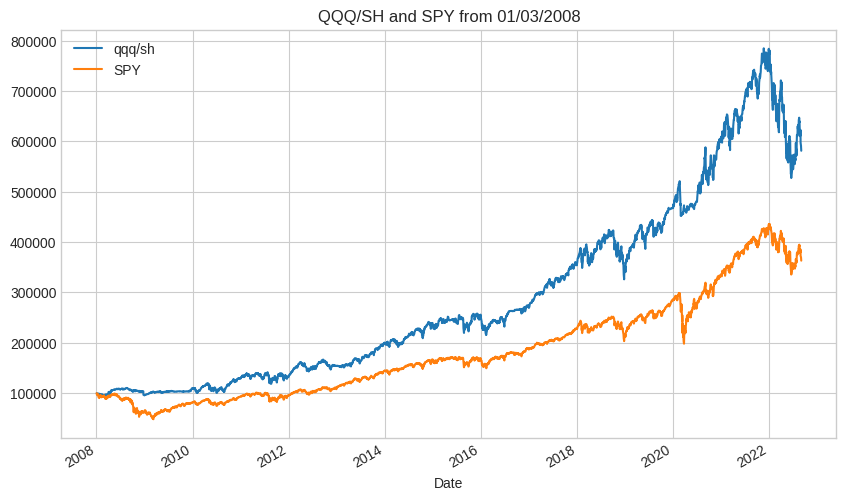

In [77]:

plot_df.plot(grid=True, title=f'QQQ/SH and SPY from {port_start_date.strftime("%m/%d/%Y")}', figsize=(10, 6))


d2012_start_date_str = '2012-01-02'
d2012_start_date: datetime = datetime.fromisoformat(d2012_start_date_str)

port_df = hedged_portfolio(holdings=holdings,
                           portfolio_asset=qqq_close_df,
                           hedge_asset=sh_close_df,
                           start_date=d2012_start_date,
                           end_date=end_date,
                           yearly_eps=eps_yearly,
                           unemployment=bls_unemployment_df)

plot_df = build_plot_data(holdings=holdings, portfolio_df=port_df, spy_df=spy_close_df)


<p>
The plot below shows the performance of the hedged QQQ portfolio from 2012.
</p>

<AxesSubplot:title={'center':'QQQ/SH and SPY from 01/02/2012'}, xlabel='Date'>

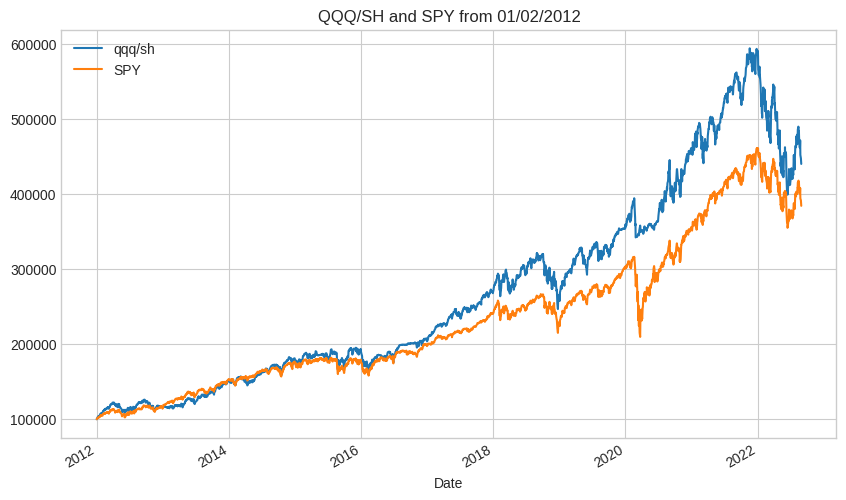

In [78]:


plot_df.plot(grid=True, title=f'QQQ/SH and SPY from {d2012_start_date.strftime("%m/%d/%Y")}', figsize=(10, 6))


<p>
The plot below shows the hedge portfolio from 2017
</p>

<AxesSubplot:title={'center':'QQQ/SH and SPY from 01/02/2017'}, xlabel='Date'>

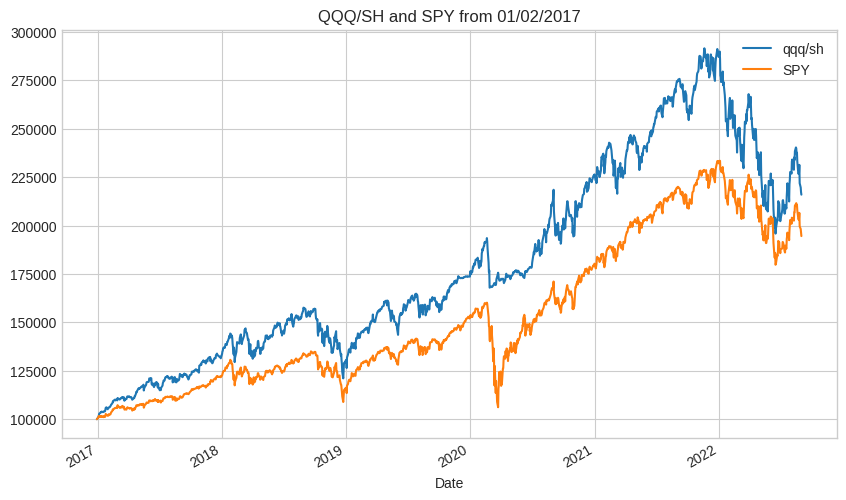

In [79]:
d2017_start_date_str = '2017-01-02'
d2017_start_date: datetime = datetime.fromisoformat(d2017_start_date_str)

port_df = hedged_portfolio(holdings=holdings,
                           portfolio_asset=qqq_close_df,
                           hedge_asset=sh_close_df,
                           start_date=d2017_start_date,
                           end_date=end_date,
                           yearly_eps=eps_yearly,
                           unemployment=bls_unemployment_df)

plot_df = build_plot_data(holdings=holdings, portfolio_df=port_df, spy_df=spy_close_df)

plot_df.plot(grid=True, title=f'QQQ/SH and SPY from {d2017_start_date.strftime("%m/%d/%Y")}', figsize=(10, 6))


<h3>
Sector ETFs with Market Timing
</h3>

<h3>
Conclusion
</h3>
<h4>
The market is not the economy
</h4>
<p>
During the COVID-19 pandemic, when businesses were closing and going out of business, the stock market went up.
This was a stark reminder that the stock market is not the economy. This is another example where fundamental factors
can fail to predict the behavior of the stock market.
</p>
<h4>
The era of value investing may return.
</h4>
<p>
There is a large literature on the application of factor models, which use fundamental factors to identify stocks that may
be promising investments. Like value (fundamental) investing in general, factor models have fallen out of favor as
the investment funds that used them to build their portfolios lagged the S&P 500.
</p>
<p>
Fundamental investing does not compare well to the overall market in market regimes characterized by asset bubbles. This includes
the period before the dot-com crash and the period after the 2007-2008 financial crash when interest rates were near zero.
Times change. In 2022 interest rates rose creating investment competition from fixed income assets. In such an environment there
can be a "flight to quality". One way to measure quality is by using fundamental factors.
</p>
<h2>
Disclaimer
</h2>
<p>
This notebook is not financial advice, investment advice, or tax advice.
The information in this notebook is for informational and recreational purposes only.
Investment products discussed (ETFs, stocks, mutual funds, etc.) are for illustrative purposes
only. This is not a recommendation to buy, sell, or otherwise transact in any of the
products mentioned. Do your own due diligence. Past performance does not guarantee
future returns.
</p>